### Set up API key

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
load_dotenv(override=True)
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

# Load data from HF into Llamaindex

In [3]:
# Load from hub
ds_vejledninger = load_dataset(
    "jealk/dk_retrieval_benchmark", split="train", download_mode="force_redownload"
)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/433 [00:00<?, ? examples/s]

In [4]:
# Create pandas dataframe from the dataset using the huggingface datasets library
df_vejledninger = ds_vejledninger.to_pandas()
df_vejledninger.head()

,url,title,html_content,text_content
0,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om regulering af satser fra 1. janu...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om regulering af satser fra 1. janu...
1,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om satser i 2024 for betaling af ud...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om satser i 2024 for betaling af ud...
2,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om obligatorisk selvbooking af jobs...,"<div class=""document-content"" id=""restylingRoo...",Vejledning om obligatorisk selvbooking af jobs...
3,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning til bekendtgørelse om tilskud til s...,"<div class=""document-content"" id=""restylingRoo...",Vejledning til bekendtgørelse om tilskud til s...
4,https://www.retsinformation.dk/eli/retsinfo/20...,Vejledning om fleksløntilskud m.v.,"<div class=""document-content"" id=""restylingRoo...",Vejledning om fleksløntilskud m.v.\n1.Indledni...


In [5]:
print(f"There is a total of {len(df_vejledninger)} documents in the dataset")

There is a total of 433 documents in the dataset


### Load into Llamaindex documents
Esentially just dicts with text and metadata

In [6]:
from llama_index import Document

# Iterate over the huggingface dataset object and create a list of llama documents
documents_vejledninger = [
    Document(text=content, metadata={"title_vejledning": name, "url": url})
    for name, content, url in zip(
        ds_vejledninger["title"],
        ds_vejledninger["text_content"],
        ds_vejledninger["url"],
    )
]

len(documents_vejledninger)

/home/jealk/mambaforge/envs/llm/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.19) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


433

In [7]:
# Inspecting the meta data of a document
documents_vejledninger[0].metadata

{'title_vejledning': 'Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde',
 'url': 'https://www.retsinformation.dk/eli/retsinfo/2024/9001'}

In [8]:
# Inspecting the text of a document
documents_vejledninger[0].text[0:500]

'Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde\nIndledning\nEfter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr. 1541 af 12. december 2023, og lov om sikring mod følger af arbejdsskade, jf. lovbekendtgørelse nr. 943 af 16. oktober 2000, skal der med virkning fra 1. '

## Chunking text
First parsing the data into nodes (llamaindex way of structuring data, including the relation to other nodes, embedding info etc.)

In [9]:
from llama_index.node_parser import SentenceSplitter
from transformers import AutoTokenizer

tokenizer_e5 = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")

# Setting max length and defining tokenizer as intended embedding model (e5)
# Splitting preferably by \n (because I formated the html so that all <p> was replaced by a \n), and if no \n is found, split by nearest delimeter char . ? ! etc.
node_parser = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=0,
    # As of 18/12/2023 the paragraph seperator expects a string
    # Some uncertainty of whether the regex is working as intended
    secondary_chunking_regex=str(["\n"]),
    paragraph_separator=str(["\n\n"]),
    tokenizer=tokenizer_e5.tokenize,
)

nodes_vejledninger = node_parser.get_nodes_from_documents(
    documents_vejledninger, show_progress=True
)

Parsing nodes:   0%|          | 0/433 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (24739 > 512). Running this sequence through the model will result in indexing errors


In [10]:
nodes_vejledninger[25].text

'1541 af 12. december 2023.\nÅrlig løbende erstatning for tab af erhvervsevne og tab af forsørger samt årlig uddannelsesgodtgørelse beregnes herefter som grundydelsen pr. 1. januar 2024, jf. ovenfor, med et tillæg på 0,0 pct.\nKapitalerstatninger for tab af erhvervsevne beregnes som den årlige løbende erstatning på afgørelsestidspunktet × kapitaliseringsfaktoren på afgørelsestidspunktet.\nMéngodtgørelsen beregnes som ménprocenten × 1.013.500 kr. Hvis tilskadekomne ved skadens indtræden var fyldt 40 år, nedsættes méngodtgørelsen med 1 pct. for hvert år tilskadekomne på skadestidspunktet var over 39 år. Hvis tilskadekomne ved skadens indtræden var fyldt 60 år, nedsættes méngodtgørelsen herudover med yderligere 1 pct. for hvert år tilskadekomne på skadestidspunktet var over 59 år. Méngodtgørelsen nedsættes ikke yderligere efter det fyldte 69. år.\nOvergangsbeløbet ved dødsfald udgør 191.000 kr.'

### (Optional chunk len vizualization)
Inspecting the distribution of token size of the chunked data

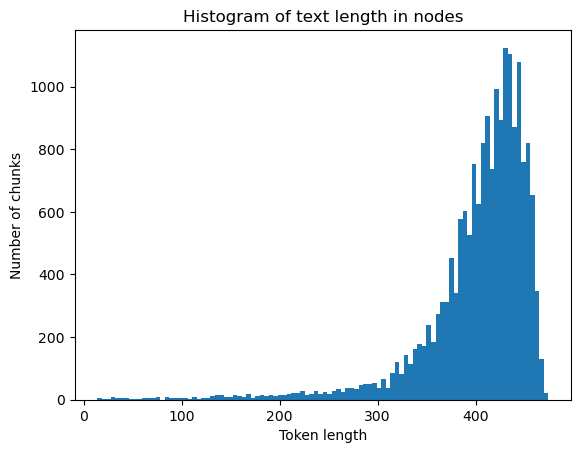

In [14]:
### Use HF tokenizer to verify length
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("intfloat/e5-base-v2")
token_counts = []
for text in [node.text for node in nodes_vejledninger]:
    token_counts.append(len(tokenizer.tokenize(text)))

# Efficient batch processing to tokenize all texts
# batch_dict = tokenizer([node.text for node in nodes_vejledninger], max_length=512, padding=True, truncation=True, return_tensors='pt')

# Plot a histogram of the length of the text in all nodes
import matplotlib.pyplot as plt

text_len = token_counts
plt.hist(text_len, bins=100)
plt.title("Histogram of text length in nodes")
plt.xlabel("Token length")
plt.ylabel("Number of chunks")
plt.show()

In [15]:
# Print first 5 examples of texts under 100 tokens
for i in range(5):
    print(f"Example {i+1} of texts under 100 tokens:")
    print(
        [
            node.text
            for node in nodes_vejledninger
            if len(tokenizer.tokenize(node.text)) < 100
        ][i]
    )
    print("\n")

Example 1 of texts under 100 tokens:
9650 af 20. juni 2022.

Beskæftigelsesministeriet, den 19. december 2023
Kirsten Brix Pedersen
/ Anne Hedegaard


Example 2 of texts under 100 tokens:
Styrelsen for Arbejdsmarked og Rekruttering, den 20. december 2023
Kirsten Brix Pedersen
/ Anne Hedegaard


Example 3 of texts under 100 tokens:
3, i retssikkerhedsbekendtgørelsen træffer Ankestyrelsen/Ankestyrelsens Beskæftigelsesudvalg afgørelse inden 4 uger efter, at klagen er modtaget.

Styrelsen for Arbejdsmarked og Rekruttering, den 19. december 2023
Jakob Heltoft
/ Astrid Finderup


Example 4 of texts under 100 tokens:
Arbejdstilsynet, den 30. oktober 2023
Sine Frederiksen
/ Helle Klostergaard Christensen


Example 5 of texts under 100 tokens:
Arbejdstilsynet, den 4. oktober 2023




**Short texts, what's happening?**

I inspected a few samples of the <100 token texts, and they mostly seem simply to be the end of documents, where this part likely could not fit into the context window of the previous chunk.


### Discarding short chunks
Discard any chunks less than 150 tokens long

In [11]:
### Use HF tokenizer to verify length

nodes_vejledninger_filtered = [
    node for node in nodes_vejledninger if len(tokenizer_e5.tokenize(node.text)) > 150
]

In [12]:
print(
    f"We now have {len(nodes_vejledninger_filtered)} chunks of text to generate questions from"
)

We now have 18423 chunks of text to generate questions from


#### Export nodes into a document store and saver for later use
The node object contains relevant info such as what node preceeded and followed it, and the meta data of the source document, both which might be relevant later. 


In [13]:
nodes_vejledninger_filtered[0]

TextNode(id_='0486bd0e-f425-4ce4-85c8-7eda4725265d', embedding=None, metadata={'title_vejledning': 'Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde', 'url': 'https://www.retsinformation.dk/eli/retsinfo/2024/9001'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='249062be-f830-41d3-bd57-ca227e007594', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'title_vejledning': 'Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde', 'url': 'https://www.retsinformation.dk/eli/retsinfo/2024/9001'}, hash='38b309944fe6155453e3117dea7104ee23212a96f2a93b5acbb957eec81f202b'), <NodeRelationship.NEXT: 

**Option to save the nodes to disk for later use**

In [37]:
"""
#To save the docs locally
from llama_index.storage.docstore import SimpleDocumentStore

# create (or load) docstore and add nodes
docstore = SimpleDocumentStore()
docstore.add_documents(nodes_vejledninger_filtered)

# persist nodes to disk
docstore.persist("data/node_store_25-11-23")
"""

'\nfrom llama_index.storage.docstore import SimpleDocumentStore\n\n# create (or load) docstore and add nodes\ndocstore = SimpleDocumentStore()\ndocstore.add_documents(nodes_vejledninger_filtered)\n\n# persist nodes to disk\ndocstore.persist("data/node_store_25-11-23")\n'

In [37]:
"""
from llama_index.storage.docstore import SimpleDocumentStore

# Load the SimpleDocumentStore from the persisted file
docstore = SimpleDocumentStore.from_persist_path("data/node_store_25-11-23")
# Create a list of nodes by list comprehension by iterating over the key (store hash) value (llamnaindex node) pairs of the docstore.docs object and appending the value to the list
nodes_vejledninger_filtered = [node for key, node in docstore.docs.items()]
"""

**Short addition to save parts of the node data in a dataframe for HF dataset creation**

In [14]:
# Create a pandas dataframe from the nodes_vejledninger_filtered object
# Only include the id_, metadata['file_name'] and text attributes of the object
import pandas as pd

df_llama_chunks = pd.DataFrame(
    [
        [node.metadata["title_vejledning"], node.id_, node.text, node.metadata["url"]]
        for node in nodes_vejledninger_filtered
    ],
    columns=["title_vejledning", "chunk_id", "chunk_text", "url"],
)
df_llama_chunks.head()

,title_vejledning,chunk_id,chunk_text,url
0,Vejledning om regulering af satser fra 1. janu...,0486bd0e-f425-4ce4-85c8-7eda4725265d,Vejledning om regulering af satser fra 1. janu...,https://www.retsinformation.dk/eli/retsinfo/20...
1,Vejledning om regulering af satser fra 1. janu...,347f812b-8ec5-4bba-8fe1-afe8dac36c51,Tilpasningsprocenten er ved Finansministeriets...,https://www.retsinformation.dk/eli/retsinfo/20...
2,Vejledning om regulering af satser fra 1. janu...,a6a196f1-2b2a-41cb-aaaa-5177f1589878,1541 af 12. december 2023 fastsættes løbende e...,https://www.retsinformation.dk/eli/retsinfo/20...
3,Vejledning om regulering af satser fra 1. janu...,8c3efbe5-c9ff-459b-ac36-1c88c0b62003,"og det maksimale årslønsbeløb, der var gældend...",https://www.retsinformation.dk/eli/retsinfo/20...
4,Vejledning om regulering af satser fra 1. janu...,b6c140e2-26d6-40be-93fa-4f2a3e49c0d2,Satser for arbejdsskader indtruffet 1. juli 20...,https://www.retsinformation.dk/eli/retsinfo/20...


In [40]:
# Save the dataframe as a csv file ensure that non ascii characters are encoded as utf-8
# df_llama_chunks.to_csv("data/chunks_id_text-14-01-24-v1.csv", encoding="utf-8")

In [48]:
# ds_llama_chunks = Dataset.from_pandas(df_llama_chunks)

## Generate Q 

**Write the Question gen prompt template**

In [31]:
from llama_index.prompts import PromptTemplate

# Define your custom prompt template in Danish
qa_sagsbehandler_tmlp = """ Nedenfor er et uddrag (kontekst) fra en længere tekst:
---------------------
{context_str}
---------------------
Givet ovenstående uddrag og ingen forudgående viden, er din opgave at generere spørgsmål til teksten.
Spørgsmålet skal indeholde specifik kontekst, således at spørgsmålet kan besvares uden tvetydighed udenfor uddraget. 
Du er en erfaren sagsbehandler, og din opgave er at stille præcis {num_questions_per_chunk} spørgsmål, som kan besvares i uddraget.
Spørgsmålene skal være af forskellig karakter og dække teksten bredt, men stilles i et sprog som en borger uden juridisk ekspertise kan forstå.
Svaret til spørgsmålet, skal kunne findes i ovenstående uddrag.

Eksempel på et spørgsmål der ikke har en specifik kontekst: 
"Hvilket dokument har den nye vejledning erstattet, og hvornår blev det tidligere dokument udsendt?", da spørgsmålet er tvetydigt og vil have flere svarmuligheder afhængigt af hvilken vejledning og dokument der refereres til.

Eksempel på et godt spørgsmål, som kan besvares uden kendskab til uddraget:
"Hvor meget vil godtgørelsen for et varigt mén være, hvis det er vurderet til 100%?"

"""

qa_sagsbehandler_tmlp = PromptTemplate(qa_sagsbehandler_tmlp)

**Generate the questions**

In [34]:
from llama_index.finetuning import generate_qa_embedding_pairs
from llama_index.llms import OpenAI

# define LLM
llm_oai = OpenAI(temperature=0.0, model="gpt-4-0125-preview")

qa_dataset = generate_qa_embedding_pairs(
    qa_generate_prompt_tmpl=qa_sagsbehandler_tmlp,
    llm=llm_oai,
    nodes=nodes_vejledninger_filtered[0:10],
    num_questions_per_chunk=2,
)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Unknown model 'gpt-4-1025-preview'. Please provide a valid OpenAI model name in: gpt-4, gpt-4-32k, gpt-4-1106-preview, gpt-4-vision-preview, gpt-4-0613, gpt-4-32k-0613, gpt-4-0314, gpt-4-32k-0314, gpt-3.5-turbo, gpt-3.5-turbo-16k, gpt-3.5-turbo-1106, gpt-3.5-turbo-0613, gpt-3.5-turbo-16k-0613, gpt-3.5-turbo-0301, text-davinci-003, text-davinci-002, gpt-3.5-turbo-instruct, text-ada-001, text-babbage-001, text-curie-001, ada, babbage, curie, davinci, gpt-35-turbo-16k, gpt-35-turbo, gpt-35-turbo-1106, gpt-35-turbo-0613, gpt-35-turbo-16k-0613

**Example of generated questions**

In [49]:
for query_id, query in qa_dataset.queries.items():
    node_id = qa_dataset.relevant_docs[query_id][0]
    text = qa_dataset.corpus[node_id]
    print(f"Spørgsmål:\n {query} \n")
    print(f"Chunk:\n {text} \n")
    break

Spørgsmål:
 Hvem har ansvaret for at justere de beløb, man kan få i erstatning ifølge arbejdsskadelovgivningen fra 1. januar 2024? 

Chunk:
 Vejledning om regulering af satser fra 1. januar 2024 efter lov om arbejdsskadesikring, lov om sikring mod følger af arbejdsskade, lov om arbejdsskadeforsikring og lov om forsikring mod følger af ulykkestilfælde
Indledning
Efter lov om arbejdsskadesikring, jf. lovbekendtgørelse nr. 1186 af 19. august 2022 med de ændringer, der følger af lov nr. 1541 af 12. december 2023, og lov om sikring mod følger af arbejdsskade, jf. lovbekendtgørelse nr. 943 af 16. oktober 2000, skal der med virkning fra 1. januar 2024 efter indstilling fra bestyrelsen for Arbejdsmarkedets Erhvervssikring ske regulering af lovens årslønsbeløb, godtgørelsesbeløb, overgangsbeløb samt løbende erstatninger.
Reguleringen af satserne fastsættes af Arbejdstilsynets direktør efter bemyndigelse fra beskæftigelsesministeren.
Satser efter loven reguleres med 2 procent tillagt tilpasnings

**Save / Load Q&A dataset**

In [75]:
# the llamaindex object only has a save_json method, so first we save the object as a json file, and then reload it as a hf dataset object in order to push to hf repo

# ensure_ascii=False is used to ensure that non ascii characters are encoded (æøå)

qa_dataset.save_json("data/data/qa_dataset_gp41106_100_samples.json", ensure_ascii=False)


In [16]:
# Push json file to hf repo

ds_qa_dataset = load_dataset('json', data_files='data_old/qa_dataset_gp41106_24-01-14_100_samples.json', encoding='utf-8')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [30]:
ds_qa_dataset['train']['queries'][0]

{'3dcf9df4-4de9-4bd4-a3d4-b69a45270e36': 'Hvem har ansvaret for at justere de beløb, man kan få i erstatning ifølge arbejdsskadelovgivningen fra 1. januar 2024?',
 'c9c51bb6-dfea-460b-942f-d8d2de40ab52': 'Med hvilken procent vil satserne for erstatning blive reguleret fra 1. januar 2024?',
 '08cd3b63-a347-40f2-a407-c917460c2532': 'Hvad er den nye tilpasningsprocent for finansåret 2024 ifølge Finansministeriets bekendtgørelse?',
 '98dd71ba-a2df-4261-a764-22a71d95cbb4': 'Fra hvilken dato vil de nye satser for arbejdsskadeserstatning, som blev nulstillet, træde i kraft ifølge den seneste lovændring?',
 'bd7eac8d-d32d-41a2-a559-86aeb9abd031': 'Hvis jeg har haft en arbejdsskade før den 1. juli 2024, vil min erstatning eller uddannelsesgodtgørelse så blive justeret op til det nye grundniveau fra den 1. januar 2024?',
 'd53bc155-cd60-4d11-828d-0171e907c684': 'Hvordan beregnes den grundløn, der ligger til grund for uddannelsesgodtgørelsen, hvis min skade skete før den 1. juli 2024?',
 '1267141

In [21]:
#Convert to pandas dataframe
df_qa_dataset = ds_qa_dataset['train'].queries.to_pandas()

AttributeError: 'Dataset' object has no attribute 'queries'

In [20]:
df_qa_dataset.head()

,queries,corpus,relevant_docs,mode
0,{'3dcf9df4-4de9-4bd4-a3d4-b69a45270e36': 'Hvem...,{'46ff9bb3-4096-43a9-ae0f-185a689a4425': 'Vejl...,{'3dcf9df4-4de9-4bd4-a3d4-b69a45270e36': ['46f...,text
